<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4:  Web Scraping for Retail Arbitrage

### Finding Underpriced RVs on Craigslist

![](https://snag.gy/WrdUMx.jpg)

In this project we will be practicing our web scraping skills.  You can use BeautifulSoup, Scrapy, Selenium or Python requests in order to complete this project.  

> In order to run code from the command line, instead of the notebook, you just need to save your code to a file (with a .py extension), and run it using the Python interpreter:<br><br>
> `python my_file.py`

You will be building a process to scrape a single category of search results on Craigslist, that can easily be applied to other categories by changing the search terms.  The main goal is to be able to target and scrape a single page given a set of parameters.

**If you use Scrapy, provide your code in a folder.**

## Import your libraries for beautifulsoup, scrapy / requests / pandas / numpy / etc
Setup whichever libraries you need. Review past material for reference.

In [2]:
# PREPARE REQUIRED LIBRARIES
import scrapy
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import requests 
import pandas as pd
import numpy as np
import re

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1(a)  Procure a list of the largest US cities from Wikipedia (non-exhaustive list)
Search, research, and scrape Wikipedia for a list of the largest US cities.  There are a few sources but find one that is in a nice table.  We don't want all cities, just signifficant cities.  Examine your source.  Look for what can be differentiable.

- Use requests
- Build XPath query(ies)
- Extract to a list
- Clean your list
- Use top 100 cities in the list

In [3]:
# SCRAPE WIKIPEDIA FOR LARGEST US CITIES (NON-EXHAUSTIVE LIST)
# USE https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population
HTML = requests.get('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population').text

# John's original broken code
# cities = Selector(text=HTML).xpath('//*[@id="mw-content-text"]/table[4]/tr/td/*[a]//text()').extract()

# John's edited broken code
# cities = Selector(text=HTML).xpath('//*[@id="mw-content-text"]/table[4]/tr/td[2]/a/text()').extract()

In [4]:
# grab list of most populous cities from Wikipedia
cities = Selector(text=HTML).xpath('//*[@id="mw-content-text"]/table[4]//td[2]//text()').extract()
len(cities)

341

#### Notes
- Originally I'd just found the city name from the Wikipedia page. Once I realized we needed the GPS coordinates as well, I went back and found I could get both the city name and GPS numbers in one scrape, so I began the process of rebuilding based on that information.

In [161]:
# get GPS and city from Wiki page
coords = Selector(text=HTML).xpath('//*[@id="mw-content-text"]/table/tr/td/small/span//span//span//span//span//text()').extract()

In [162]:
# create list of cities and their coordinates
gps_city = [[coords[n].encode('UTF8'),coords[n+1].encode('UTF8')] for n in range(0,len(coords),2)]

In [163]:
# clean data
gps_city_name_fix = [[i[0], re.sub('^\d*\s?', '', i[1])] for i in gps_city]
gps_city = [[i[0].replace(" ", "").replace(';',','), i[1]] for i in gps_city_name_fix]

In [164]:
gps_city[:5]

[['40.6643,-73.9385', 'New York City'],
 ['34.0194,-118.4108', 'Los Angeles'],
 ['41.8376,-87.6818', 'Chicago'],
 ['29.7805,-95.3863', 'Houston'],
 ['40.0094,-75.1333', 'Philadelphia']]

In [165]:
# create dataframe from our list
data = pd.DataFrame(gps_city, columns=['GPS_coordinates','City_Name'])

In [166]:
data.head()

,GPS_coordinates,City_Name
0,"40.6643,-73.9385",New York City
1,"34.0194,-118.4108",Los Angeles
2,"41.8376,-87.6818",Chicago
3,"29.7805,-95.3863",Houston
4,"40.0094,-75.1333",Philadelphia


In [178]:
with open('/Users/deepstructure/Dropbox/DataScience/misc/google_distance_api_id.txt', 'r') as f:
    key = f.readlines()[0]

In [210]:
import json

def find_distance(x):
    JSON = requests.get('https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins=34.0194,-118.4108&destinations='+x+'&key='+key)        
    try:
        j_file = JSON.json()
        return j_file['rows'][0]['elements'][0]['distance']['text'].split(" ")[0].replace(",", "")
    except:
        return np.nan

In [211]:
data['Distance_from_LosAngles'] = data['GPS_coordinates'].apply(find_distance)

In [212]:
data.head()

,GPS_coordinates,City_Name,Distance_from_LosAngles
0,"40.6643,-73.9385",New York City,2810
1,"34.0194,-118.4108",Los Angeles,1
2,"41.8376,-87.6818",Chicago,2036
3,"29.7805,-95.3863",Houston,1556
4,"40.0094,-75.1333",Philadelphia,2722


#### It's 5p on Friday and I have to leave. So I'm submitting as is.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1(b) Clean Your List

Optionally, filter out any cities with impropper ASCII characters.  A smaller list will be easier to look at.  However you may not need to filter these if you spend more time scraping a more concise city list.  This list should help you narrow down the list of regional Craigslist sites.

In [63]:
# ONLY RETAIN PROPERLY FORMED CITY NAMES
regex = re.compile(r'\[\d+\]')
cities2 = filter(lambda i: not regex.search(i), cities)
cities3 = [x.encode('UTF8') for x in cities2[:100]]
city = cities3

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2(a)  Write a function to capture current pricing information via Craigslist in one city.
Choose a city from your scraped data, then go to the cooresponding city section on Craigslist, searching for "rv" in the auto section.  Write a method that pulls out the prices.

In [64]:
def get_rv_price(x):
    rvs = requests.get(x).text
    prices = Selector(text=rvs).xpath('//*[@id="sortable-results"]/div[1]/p/a/span/text()').extract()
    prices2 = [int(i.strip('$')) for i in prices]
    return prices2

get_rv_price('http://losangeles.craigslist.org/search/sss?query=rv+gulfstream&sort=rel&min_price=7000')


[9800, 49900, 8500, 29995, 9800, 12000, 45000]

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Create a function that creates search string URLs to repeat the procedcure upon the list of cities obtained from Wikipedia cities

Major US cities on Craigslist typically have their own corresponding section (ie: SFBay Area, NYC, Boston, Miami, Seattle, etc).  Later, you will use these to query search results for various metropolitian regions listed on Craigslist.  Between the major metropolitan Craigslist sites, the only thing that will differ is the URL's that correspond to them.

The point of the "mapping":  Create a data structure that allows you to iterate with both the name of the city from Wikipedia, with the cooresponding variable that that will allow you to construct each craigslist URL for each region.

> For San Francsico (the Bay Area metropolitan area), the url for the RV search result is:
> http://sfbay.craigslist.org/search/sss?query=rv
>
> The convention is http://[region].craigslist.org/search/sss?query=rf
> Replacing [region] with the corresponding city name will allow you to quickly iterate through each regional Craigslist site, and scrape the prices from the search results.  


In [ ]:
HTML = requests.get('https://www.craigslist.org/about/sites#US').text

urls = Selector(text=HTML).xpath('//*[@id="pagecontainer"]/section/div[3]/div/ul/li/a').extract()

urls2 = [x.encode('UTF8') for x in urls]
urls2[0]



In [ ]:
# regex = re.compile()

city_dict = {}

for i in urls:
    y = str(re.findall(r'\/\/(.*)\"', i)[0]).strip('/')
    w = str(re.findall(r'\>(.*)\<', i)[0])
    city_dict[w] = y
    

In [ ]:
city_dict.items()[:3]

In [ ]:
city # list of top 100 populated cities from Wikipedia
city_dict # dictionary of Craigslist site URLs with respective city as keys

def get_search_url(citi):
    for key in city_dict.keys():
        if citi.lower() in key:
            return 'http://'+city_dict[key]+'/search/sss?query=rv+gulfstream&sort=rel&min_price=7000'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Define a function to calculate mean and median price per city.

Now that you've created a list of cities you want to scrape, adapt your solution for grabbing data in one region site, to grab data for all regional sites that you collected, then calculate the mean and median price of RV results from each city.

> Look at the URLs from a few different regions (ie: portland, phoenix, sfbay), and find what they have in common.  Determine the area in the URL string that needs to change the least, and figure out how to replace only that portion of the URL in order to iterate through each city.

In [ ]:
def mean_med(citi):  # where x is a city name
    y = get_search_url(citi)
    if y:
        yl = get_rv_price(y)
        city_mean = np.mean(yl)
        city_median = np.median(yl)
        return citi, len(yl), city_mean, city_median, y
    else:
        return (citi, np.nan, np.nan, np.nan, y)
    
mean_med('Tampa')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Run your scraping process, and save your results to a CSV file.

In [ ]:
import csv
import sys

with open('assets/rv_cities_nums.csv', 'w') as f:
    datawrite = csv.writer(f, delimiter=',')
    datawrite.writerow(['City', 'Quantity', 'Mean_RV_price', 'Median_RV_price', 'URL'])
    for i in city:
        datawrite.writerow(mean_med(i))


In [ ]:
# with open('rv_cities_nums.csv', 'r') as f:
#     dataread = csv.reader(f, delimiter=',')
#     for row in dataread:
#         print row

In [ ]:
rv = pd.read_csv('assets/rv_cities_nums.csv')
rv.info()

In [ ]:
rv['Quantity'].unique()

In [ ]:
rv = rv.dropna()
rv.info()

In [ ]:
rv.info()

In [ ]:
# with open('assets/rv_cities_nums_cleaned.csv', 'w') as f:
#     datawrite = csv.writer(f, delimiter=',')
#     datawrite.writerow(['City', 'Quantity', 'Mean_RV_price', 'Median_RV_price', 'URL'])
#     for i in rv:
#         datawrite.writerow(i)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Do an analysis of the RV market.  Are there any other variables you could pull out of the markup to help describe your dataset?

Go head we'll wait.  Anything notable about the data?

- From the main search results page for each city (e.g. http://chicago.craigslist.org/search/sss?query=rv+gulfstream&sort=rel&min_price=7000), the only other available data is:
    - the title text for the post, which often contains the year and model of the RV (make is selected for in the search URL)
    - the accompanying photo.
- a further dive into the individual posts could reveal more descriptive information about the RV in the main body tag

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7. Does it makes sense to buy RVs in one region and sell them in another?

### Use the Google Distance API to inform your decision.

Assuming the cost of shipping or driving from one regional market to another.

In [ ]:
rv.sort_values(by='Median_RV_price', ascending=False)[:10]

In [ ]:
rv.sort_values(by='Median_RV_price', ascending=False)[-10:]

#### Conclusions:
- based simply on this information I wouldn't consider buying RVs in one area to sell in another. Perhaps with stronger data (parsing of the title tag text), regarding the age and model of the RV, one could make better comparison.
- it could be possible that Florida may be a good market, as three of it's cities are in the top 10 for median sale price. Perhaps buying a RV from a city in the bottom of the median list and taking it to Florida could be worth it, although the fact that there's also a very large amount of RVs for sale in Tampa and Orlando may work against that idea. 
- I completely forgot that we were trying to sell RVs to Burning Man attendees.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 8.  Choose another area of Craigslist to scrape where retail arbitrage might be possible.

#### Cross-reference possible opportunities with the eBay API Interface.

**Choose an area having more than a single page of results, then scrape multiple regions, multiple pages of search results and or details pages.**

This is the true exercise of being able to understand how to successfully plan, develop, and employ a broader scraping strategy.  Even though this seems like a challenging task, a few tweeks of your current code can make this very managable if you've pieced together all the touch points.  If you are still confused as to some of the milestones within this process, this is an excellent opportunity to round out your understanding, or help you build a list of questions to fill in your gaps.

_Use Scrapy!  Provide your code in this project directory when you submit this project._

# Project 4.1: Classification

A few weeks ago we imputed age values in the titanic dataset. Now we're going to use those imputed values to predict survivorship using "Pclass", "Sex", "Age", "SibSp", "Parch", and "Fare". Get the traning and testing data from here: https://www.kaggle.com/c/titanic/data (you will need to make an account). Copy your imputation code below.

In [115]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('assets/titanic/train.csv')
df_test = pd.read_csv('assets/titanic/test.csv')

In [116]:
df_train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [117]:
df_test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [118]:
# create a function of our apellation discovery process so we can call it 
def find_appel(i):
    t = i.split(',')
    u = t[1].strip()
    v = u.split('.')
    w = v[0]
    return w

# add an apellation column to our dataframe
df_train['apell'] = df_train['Name'].apply(find_appel)
df_test['apell'] = df_test['Name'].apply(find_appel)

In [119]:
# fill in the NaN values in the age column with our imputed ages
df_train['Age'] = df_train['Age'].fillna(df_train.groupby("apell")['Age'].transform("mean"))
df_test['Age'] = df_test['Age'].fillna(df_test.groupby("apell")['Age'].transform("mean"))

In [120]:
# check that we've filled in all NaN values
df_test['Age'] = df_test['Age'].fillna(32.00)
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

In [121]:
# delete unnecessary columns
for i in ['PassengerId', 'Name', 'Ticket', 'Cabin' , 'Embarked', 'apell']:
    del df_train[i]

for i in ['PassengerId', 'Name', 'Ticket', 'Cabin' , 'Embarked', 'apell']:
    del df_test[i]

In [122]:
# convert variables to categories
for i in ['Survived', 'Pclass', 'Sex']:
    df_train[i] = df_train[i].astype('category')
for i in ['Pclass', 'Sex']:
    df_test[i] = df_test[i].astype('category')

In [135]:
df_train['Sex'] = pd.get_dummies(df_train['Sex'],drop_first=True)

In [136]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1.0,22.0,1,0,7.2500
1,1,1,0.0,38.0,1,0,71.2833
2,1,3,0.0,26.0,0,0,7.9250
3,1,1,0.0,35.0,1,0,53.1000
4,0,3,1.0,35.0,0,0,8.0500


In [151]:
df_test['Sex'] = pd.get_dummies(df_test['Sex'],drop_first=True)

In [152]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1.0,34.5,0,0,7.8292
1,3,0.0,47.0,1,0,7.0000
2,2,1.0,62.0,0,0,9.6875
3,3,1.0,27.0,0,0,8.6625
4,3,0.0,22.0,1,1,12.2875


Predict using kNN with k=1,2,3,4,5,6,7,8,9

In [200]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [201]:
scaler.fit(df_train.drop('Survived',axis=1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [203]:
scaled_features = scaler.transform(df_train.drop('Survived',axis=1))

In [210]:
df_feat = pd.DataFrame(scaled_features, columns=df_train.columns[1:])

In [212]:
df_feat.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,0.827377,0.737695,-0.584387,0.432793,-0.473674,-0.502445
1,-1.566107,-1.355574,0.621365,0.432793,-0.473674,0.786845
2,0.827377,-1.355574,-0.282949,-0.474545,-0.473674,-0.488854
3,-1.566107,-1.355574,0.395286,0.432793,-0.473674,0.420730
4,0.827377,0.737695,0.395286,-0.474545,-0.473674,-0.486337


In [213]:
X = df_feat
y = df_train['Survived']

In [214]:
from sklearn.neighbors import KNeighborsClassifier

In [230]:
knn = KNeighborsClassifier(n_neighbors=5)

In [231]:
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [232]:
scaler2 = StandardScaler()
scaler.fit(df_test)
scaled_features2 = scaler.transform(df_test)
df_feat2 = pd.DataFrame(scaled_features2, columns=df_test.columns)

In [233]:
df_feat2.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,0.873482,0.755929,0.329723,-0.499470,-0.400248,-0.498407
1,0.873482,-1.322876,1.291647,0.616992,-0.400248,-0.513274
2,-0.315819,0.755929,2.445957,-0.499470,-0.400248,-0.465088
3,0.873482,0.755929,-0.247432,-0.499470,-0.400248,-0.483466
4,0.873482,-1.322876,-0.632202,0.616992,0.619896,-0.418471


In [234]:
predictions2 = knn.predict(df_feat2)

In [235]:
td2 = pd.read_csv('assets/template_gendermodel.csv')

In [236]:
del td2['Survived']

In [237]:
titanic_predict2 = pd.DataFrame(predictions2)

In [238]:
td2['Survived'] = titanic_predict2

In [239]:
td2.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [240]:
td2.to_csv(path_or_buf='assets/titanic_predictions_knn.csv', sep=',', index = False)

Predict using logistic Regression

In [137]:
from sklearn.cross_validation import train_test_split

In [153]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

In [154]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [155]:
from sklearn.linear_model import LogisticRegression

In [156]:
logmodel = LogisticRegression()

In [157]:
logmodel.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [160]:
X_test = df_test

In [162]:
predictions = logmodel.predict(X_test)

In [166]:
titanic_predict = pd.DataFrame(predictions)

In [171]:
len(titanic_predict)

418

In [190]:
td = pd.read_csv('assets/template_gendermodel.csv')

In [191]:
del td['Survived']

In [192]:
td['Survived'] = titanic_predict

In [193]:
td.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [196]:
td.to_csv(path_or_buf='assets/titanic_predictions_log.csv', sep=',', index = False)

Submit your predictions to kaggle. what place did you get on the leader board.

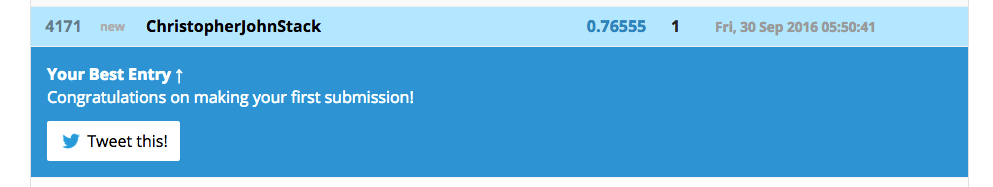

In [243]:
from IPython.display import Image
Image(filename='assets/kaggle_titanic_log_entry_4171.png')  

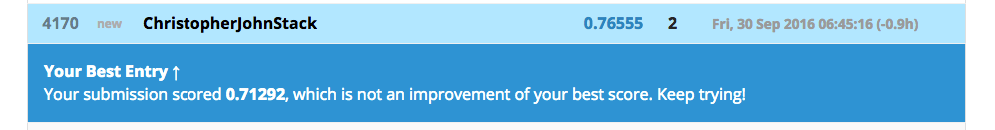

In [244]:
Image(filename='assets/kaggle_titanic_knn1_entry_4170.png') 

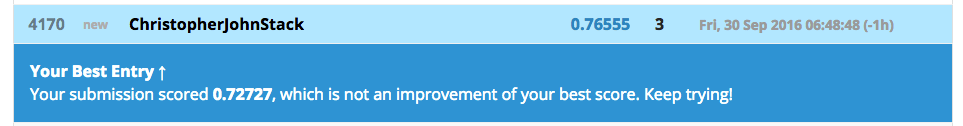

In [245]:
Image(filename='assets/kaggle_titanic_knn5_entry_4170.png')